# Build Models, WR Insights

In this notebook we take the data reductions for the 17-week data from the other notebook and build GMM and K-means models, as well as examine WR performance against their given matchups.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from ipywidgets import interact, fixed

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib.animation import FFMpegWriter
pd.set_option('max_columns', 100)

import dateutil
from math import radians
from IPython.display import Video

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import os
import warnings
from tqdm import tqdm
import gc
warnings.filterwarnings('ignore')

In [2]:
%%time
plays = pd.read_csv('nfl-big-data-bowl/pass-2018.csv')
players = pd.read_csv('nfl-big-data-bowl/players.csv')
weekMod = pd.read_csv('weekModpos.csv')

Wall time: 57.2 s


In [3]:
weekMod

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,oppMinDist,closestOpp(nflId),oppDir,oppX,oppY,oppO,mateMinDist,closestMate(nflId),mateX,mateY,mateO,diffDir,oppMateDistRatio,orientDiff,varX,varY,varS,oppVar,oppMean,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio,orientMean,orientVar,oppOrientMean,oppOrientVar
0,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,before_snap,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN,1.916899,2533040.0,193.97,90.78,36.15,257.61,5.867759,2552315.0,86.48,31.12,95.90,127.31,0.289672,151.98,0.000036,0.000189,0.000000,0.000025,1.918109,0.000972,5.882770,2637.883442,193.817273,0.290676,0.000005,104.972727,2.080822,153.522727,3.405102
1,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,before_snap,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000096,0.000147,0.000067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,290.366364,0.076945,NaN,NaN
2,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,before_snap,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN,4.983252,2555415.0,151.83,91.29,21.83,250.34,3.929377,2552689.0,82.67,20.53,81.14,17.08,0.571639,180.22,0.003216,0.000187,0.001645,0.002955,4.912147,0.005817,4.013412,463.282687,63.215455,0.562519,0.000056,71.297273,0.259502,179.842727,0.244062
3,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,before_snap,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000016,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.495455,0.386487,NaN,NaN
4,2018-09-07T01:07:14.599Z,73.64,28.70,0.03,0.02,0.01,103.05,219.41,before_snap,2534832.0,Rodney McLeod,23.0,FS,1,home,2018090600,75,left,NaN,18.203544,310.0,240.93,91.73,26.67,289.57,12.174243,2558175.0,85.63,26.59,87.69,21.52,2.983931,186.52,0.000125,0.000025,0.000027,0.000160,18.221115,0.000097,12.190637,44.362445,14.143636,1.903102,0.286890,106.722727,6.786162,177.763636,63.941565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9204102,2018-12-31T04:23:24.200Z,69.35,44.50,2.77,1.11,0.27,139.16,163.48,after_throw,2557870.0,Taywan Taylor,13.0,WR,102,home,2018123011,4261,left,OUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.352478,7.476465,4.051283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.245000,6567.919656,NaN,NaN
9204103,2018-12-31T04:23:24.200Z,75.15,7.40,1.01,0.33,0.10,98.38,94.89,after_throw,2557961.0,Quincy Wilson,31.0,CB,102,away,2018123011,4261,left,NaN,18.238654,2495469.0,159.55,89.49,18.67,144.86,15.952429,2558060.0,72.95,23.20,110.13,64.66,1.063533,46.48,15.078428,0.153240,1.075148,17.439120,12.221519,6.095774,13.380294,1738.102269,40.140758,1.082268,0.360038,82.333788,358.921556,34.078485,959.965890
9204104,2018-12-31T04:23:24.200Z,72.95,23.20,3.95,0.60,0.40,110.13,105.63,after_throw,2558060.0,Malik Hooker,29.0,FS,102,away,2018123011,4261,left,NaN,17.149125,2495469.0,159.55,89.49,18.67,144.86,10.640075,238227.0,83.59,23.24,103.12,53.92,2.297917,34.73,46.350359,4.698738,1.490008,6.196123,16.255670,0.753865,11.072299,2440.810022,37.011970,3.516815,2.249848,112.010909,53.955082,39.346364,1621.818230
9204105,2018-12-31T04:23:24.200Z,101.94,14.60,5.63,2.24,0.57,139.23,119.97,after_throw,2558976.0,Kenny Moore,23.0,CB,102,away,2018123011,4261,left,NaN,7.044778,2558942.0,118.54,95.77,11.20,103.97,11.082599,2540219.0,95.10,5.88,109.39,1.43,1.313828,35.26,120.948231,43.914912,2.039161,1.742344,6.823583,1.620042,9.627150,1219.311572,35.025909,1.406579,3.714749,121.752727,202.552672,40.029848,2311.644718


In [4]:
weekMod.columns[33:44]

Index(['varX', 'varY', 'varS', 'oppVar', 'oppMean', 'mateVar', 'mateMean',
       'oppDirVar', 'oppDirMean', 'meanOppMateDistRatio',
       'varOppMateDistRatio'],
      dtype='object')

# Build GMM and K-means Models

In [5]:
def gmm_km(weekMod, position='SS', seed=2022):
    X = weekMod.loc[(weekMod['position']==position)][weekMod.columns[33:]].dropna()
    xTrain = X.drop_duplicates()

    ## scale the data, required for unsupervised data
    scaler = MinMaxScaler()
    scaler.fit(xTrain)
    xTrainScaled = scaler.transform(xTrain)

    ## train the GMM
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=seed)
    gmm.fit(xTrainScaled)
    ## make class prediction and probability estimation
    gm_pred = gmm.predict(X)
    gm_prob = gmm.predict_proba(X)

    ## train the K-means model
    km = KMeans(n_clusters=2, random_state=seed)
    km.fit(xTrainScaled)
    km_pred = km.predict(X)
    
    X['gm_cluster'] = gm_pred
    X['gm_cluster_prob'] = gm_prob[:,0]
    X['km_cluster'] = km_pred
    
    return X

In [6]:
%%time
X_ss = gmm_km(weekMod, position='SS')
X_fs = gmm_km(weekMod, position='FS')
X_cb = gmm_km(weekMod, position='CB')
X = pd.concat([X_ss, X_fs, X_cb])

Wall time: 24.9 s


In [7]:
%%time
## join the class prediction and probability estimation into our main dataframe
weekFin = weekMod.join(X[['gm_cluster', 'gm_cluster_prob', 'km_cluster']])

Wall time: 4.13 s


In [8]:
del weekMod
gc.collect()

34

In [44]:
# convert coverage to names for visualization:
# NEED TO DO THIS BY THE POSITION VALUE, CLUSTERS ARE NOT STANDARD ACROSS POSITIONS
# these values were determined after visually examining play labels in visualization of football field below
weekFin['gm_coverage'] = ['Zone' if (pos=='SS' and gmcl==1) or (pos=='FS' and gmcl==1) or (pos=='CB' and gmcl==1) else
                          'Man' if (pos=='SS' and gmcl!=1) or (pos=='FS' and gmcl!=1) or (pos=='CB' and gmcl!=1)
                         else np.nan for pos, gmcl in zip(weekFin['position'], weekFin['gm_cluster'])]

weekFin['km_coverage'] = ['Zone' if (pos=='SS' and kmcl==0) or (pos=='FS' and kmcl==1) or (pos=='CB' and kmcl==0) else
                          'Man' if (pos=='SS' and kmcl!=0) or (pos=='FS' and kmcl!=1) or (pos=='CB' and kmcl!=0)
                         else np.nan for pos, kmcl in zip(weekFin['position'], weekFin['km_cluster'])]

In [45]:
print(weekFin['gm_coverage'].value_counts())
print(weekFin['km_coverage'].value_counts())

Man     3319389
Zone    2485475
Name: gm_coverage, dtype: int64
Man     3214219
Zone    2590645
Name: km_coverage, dtype: int64


## Visualize Key Differences Between Coverages / Positions

First we will get the total number of plays classified by unique FS, SS, and CB, then count how many coverages are seen by each position group and plot it. We could use it as a percentage of whole in zone, 1-pct is man, then use stacked bar chart.

Another interesting visual would be Man:Zone coverage by player.

In [46]:
## FS, gmm
print(pd.DataFrame(weekFin.loc[weekFin['position']=='FS'].groupby(['gameId','playId','nflId'])['gm_coverage'].value_counts())\
.index.get_level_values('gm_coverage')\
.value_counts())

## FS, km
print(pd.DataFrame(weekFin.loc[weekFin['position']=='FS'].groupby(['gameId','playId','nflId'])['km_coverage'].value_counts())\
.index.get_level_values('km_coverage')\
.value_counts())

Zone    19810
Man       213
Name: gm_coverage, dtype: int64
Zone    19806
Man      1168
Name: km_coverage, dtype: int64


In [47]:
## SS, gmm
print(pd.DataFrame(weekFin.loc[weekFin['position']=='SS'].groupby(['gameId','playId','nflId'])['gm_coverage'].value_counts())\
.index.get_level_values('gm_coverage')\
.value_counts())

## SS, km
print(pd.DataFrame(weekFin.loc[weekFin['position']=='SS'].groupby(['gameId','playId','nflId'])['km_coverage'].value_counts())\
.index.get_level_values('km_coverage')\
.value_counts())

Zone    15738
Man       349
Name: gm_coverage, dtype: int64
Zone    15738
Man       500
Name: km_coverage, dtype: int64


In [48]:
## CB, gmm
print(pd.DataFrame(weekFin.loc[weekFin['position']=='CB'].groupby(['gameId','playId','nflId'])['gm_coverage'].value_counts())\
.index.get_level_values('gm_coverage')\
.value_counts())

## CB, km
print(pd.DataFrame(weekFin.loc[weekFin['position']=='CB'].groupby(['gameId','playId','nflId'])['km_coverage'].value_counts())\
.index.get_level_values('km_coverage')\
.value_counts())

Man     53682
Zone    15325
Name: gm_coverage, dtype: int64
Man     53626
Zone     9923
Name: km_coverage, dtype: int64


  Pos   ZonePct    ManPct
0  FS  0.875614  0.124386
1  SS  0.938454  0.061546
2  CB  0.529439  0.470561


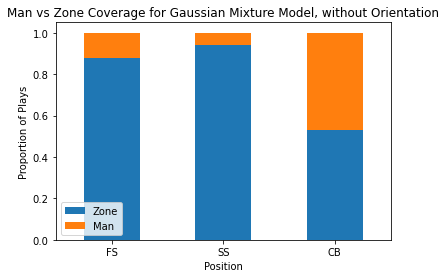

In [14]:
## consolidate, plot for GMM values
## with orientation: pos_plot = pd.DataFrame({'Pos':['FS','SS','CB'],'Zone':[19810,15738,15325],'Man':[213,349,53682]})
## without orientation result:
pos_plot = pd.DataFrame({'Pos':['FS','SS','CB'],'Zone':[19795,15736,48548],'Man':[2812,1032,43149]})
pos_plot['ZonePct'] = pos_plot.Zone / (pos_plot.Zone + pos_plot.Man)
pos_plot['ManPct'] = pos_plot.Man / (pos_plot.Zone + pos_plot.Man)
pos_plot.drop(['Zone','Man'], axis=1, inplace=True)
print(pos_plot)


pos_plot.set_index('Pos').plot(kind='bar', stacked=True)
plt.xticks(rotation=0)
plt.xlabel("Position")
plt.ylabel("Proportion of Plays")
plt.legend(labels=['Zone','Man'], loc='lower left')
plt.title('Man vs Zone Coverage for Gaussian Mixture Model, without Orientation')
plt.savefig('overleaf-figs/gmm_mz_no_O.png')
plt.show()

  Pos   ZonePct    ManPct
0  FS  0.990896  0.009104
1  SS  0.989500  0.010500
2  CB  0.990968  0.009032


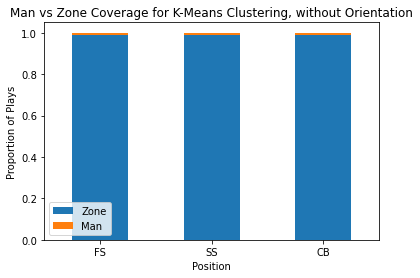

In [15]:
## consolidate, plot for KM values
## with orientation: pos_plot = pd.DataFrame({'Pos':['FS','SS','CB'],'Zone':[19806,15738,9923],'Man':[1186,500,53626]})
## without orientation:
pos_plot = pd.DataFrame({'Pos':['FS','SS','CB'],'Zone':[19810,15738,53653],'Man':[182,167,489]})
pos_plot['ZonePct'] = pos_plot.Zone / (pos_plot.Zone + pos_plot.Man)
pos_plot['ManPct'] = pos_plot.Man / (pos_plot.Zone + pos_plot.Man)
pos_plot.drop(['Zone','Man'], axis=1, inplace=True)
print(pos_plot)


pos_plot.set_index('Pos').plot(kind='bar', stacked=True)
plt.xticks(rotation=0)
plt.xlabel("Position")
plt.ylabel("Proportion of Plays")
plt.legend(labels=['Zone','Man'], loc='lower left')
plt.title('Man vs Zone Coverage for K-Means Clustering, without Orientation')
plt.savefig('overleaf-figs/km_mz_no_O.png')
plt.show()

In [49]:
## function to plot player coverage percentages
## all plotted players have min 100 plays
def player_coverages(weekFin, position='CB'):
    ## gets the number of CB by player name
    tmp = pd.DataFrame(weekFin.loc[weekFin['position']==position].groupby(['gameId','playId','nflId','gm_coverage'])['displayName']\
                 .value_counts()).rename(columns={'displayName':'count'}).reset_index()

    ## gets this by events for which the player is in man/zone
    to_plot = pd.DataFrame(tmp.groupby(['displayName','gm_coverage'])['gm_coverage'].agg('value_counts')\
                 .rename_axis(['name','cov','cov1'])).reset_index().drop('cov1',axis=1)
    ## organization of names for plot
    player_cov = to_plot.reset_index().pivot(index='name', columns='cov', values='gm_coverage').reset_index()
    ## only keep those with min 100 plays
    player_cov = player_cov.loc[(player_cov['Man'] > 100) | (player_cov['Zone'] > 100)]
    
    ## calculate man/zone percentages
    player_cov['ZonePct'] = player_cov.Zone / (player_cov.Zone + player_cov.Man)
    player_cov['ManPct'] = player_cov.Man / (player_cov.Zone + player_cov.Man)
    player_cov.drop(['Zone','Man'], axis=1, inplace=True)
    player_cov.rename(columns={'ZonePct':'Zone', 'ManPct':'Man'}, inplace=True)
    
    ## produce top 10 man
    player_cov.sort_values('Man', ascending=False).head(10).set_index('name').plot(kind='bar', stacked=True)
    plt.xticks(rotation=90)
    plt.xlabel("Player")
    plt.ylabel("Proportion of Plays")
    if position=='CB':
        loc='upper right'
    else:
        loc='lower left'
    plt.legend(labels=['Zone','Man'], loc=loc)
    plt.title(f'Top 10 {position} by Man Coverage')
    plt.tight_layout()
    plt.savefig(f'overleaf-figs/top10man{position}.png', bbox_inches = "tight")
    plt.show()
    ## top 10 zone plot
    player_cov.sort_values('Zone', ascending=False).head(10).set_index('name').plot(kind='bar', stacked=True)
    plt.xticks(rotation=90)
    plt.xlabel("Position")
    plt.ylabel("Proportion of Plays")
    plt.legend(labels=['Zone','Man'], loc=loc)
    plt.title(f'Top 10 {position} by Zone Coverage')
    plt.tight_layout()
    plt.savefig(f'overleaf-figs/top10zone{position}.png', bbox_inches = "tight")
    plt.show()
    
    return player_cov

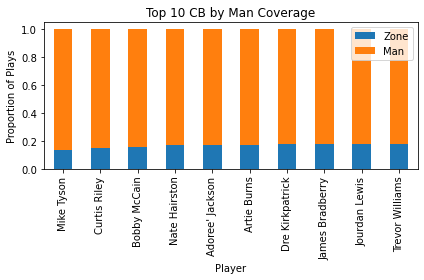

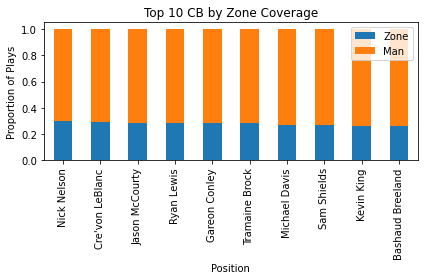

In [50]:
cb_plot = player_coverages(weekFin=weekFin, position='CB')

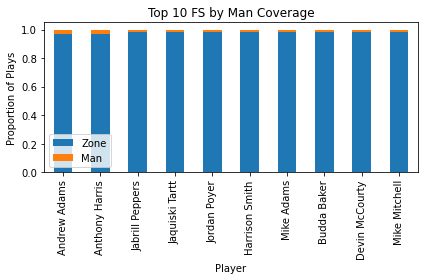

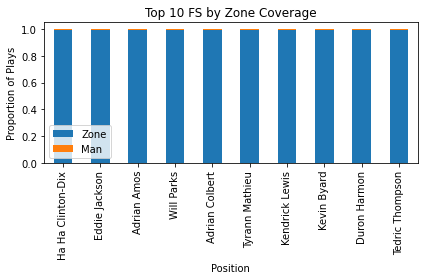

In [51]:
fs_plot = player_coverages(weekFin=weekFin, position='FS')

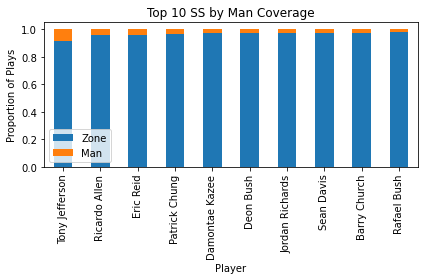

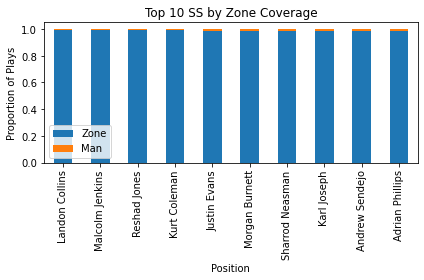

In [52]:
ss_plot = player_coverages(weekFin=weekFin, position='SS')

## Implement Visualization of Tracking Data

This is credited to the Kaggle notebooks mentioned in the other notebook..

In [20]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=55,
                          highlight_first_down_line=False,
                          yards_to_go=10,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        #plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')
        
    if highlight_first_down_line:
        fl = hl + yards_to_go
        plt.plot([fl, fl], [0, 53.3], color='yellow')
        #plt.text(fl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')
    return fig, ax

def calculate_dx_dy_arrow(x, y, angle, speed, multiplier):
    if angle <= 90:
        angle = angle
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 90 and angle <= 180:
        angle = angle - 90
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = -np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 180 and angle <= 270:
        angle = angle - 180
        dx = -(np.sin(radians(angle)) * multiplier * speed)
        dy = -(np.cos(radians(angle)) * multiplier * speed)
        return dx, dy
    if angle > 270 and angle <= 360:
        angle = 360 - angle
        dx = -np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    
        
def animate_player_movement(weekData, playId, gameId):
    playData = pd.read_csv('nfl-big-data-bowl/pass-2018.csv')
    
    playHome = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "home"')
    playAway = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "away"')
    playFootball = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "football"')
    
    playHome['time'] = playHome['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playAway['time'] = playAway['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playFootball['time'] = playFootball['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    
    maxTime = int(playAway['time'].unique().max())
    minTime = int(playAway['time'].unique().min())
    
    yardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardlineNumber'].item()
    yardsToGo = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardsToGo'].item()
    absoluteYardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['absoluteYardlineNumber'].item() - 10
    playDir = playHome.sample(1)['playDirection'].item()
    
    if (absoluteYardlineNumber > 50):
        yardlineNumber = 100 - yardlineNumber
    if (absoluteYardlineNumber <= 50):
        yardlineNumber = yardlineNumber
        
    if (playDir == 'left'):
        yardsToGo = -yardsToGo
    else:
        yardsToGo = yardsToGo
    
    fig, ax = create_football_field(highlight_line=True, highlight_line_number=yardlineNumber, highlight_first_down_line=True, yards_to_go=yardsToGo)
    playDesc = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['playDescription'].item()
    plt.title(f'Game # {gameId} Play # {playId} \n {playDesc}')
    
    def update_animation(time):
        patch = []
        
        homeX = playHome.query('time == ' + str(time))['x']
        homeY = playHome.query('time == ' + str(time))['y']
        homeNum = playHome.query('time == ' + str(time))['jerseyNumber']
        homeOrient = playHome.query('time == ' + str(time))['o']
        homeDir = playHome.query('time == ' + str(time))['dir']
        homeSpeed = playHome.query('time == ' + str(time))['s']
        homePosition = playHome.query('time == ' + str(time))['position']
        homeCluster = playHome.query('time == ' + str(time))['gm_cluster']
        homeClusterProb = playHome.query('time == ' + str(time))['gm_cluster_prob']
        homeCoverage = playHome.query('time == ' + str(time))['gm_coverage']
        homeRoute = playHome.query('time == ' + str(time))['route']
        patch.extend(plt.plot(homeX, homeY, 'o',c='gold', ms=20, mec='white', zorder=3))
        
        awayX = playAway.query('time == ' + str(time))['x']
        awayY = playAway.query('time == ' + str(time))['y']
        awayNum = playAway.query('time == ' + str(time))['jerseyNumber']
        awayOrient = playAway.query('time == ' + str(time))['o']
        awayDir = playAway.query('time == ' + str(time))['dir']
        awaySpeed = playAway.query('time == ' + str(time))['s']
        awayPosition = playAway.query('time == ' + str(time))['position']
        awayCluster = playAway.query('time == ' + str(time))['gm_cluster']
        awayClusterProb = playAway.query('time == ' + str(time))['gm_cluster_prob']
        awayCoverage = playAway.query('time == ' + str(time))['gm_coverage']
        awayRoute = playAway.query('time == ' + str(time))['route']
        patch.extend(plt.plot(awayX, awayY, 'o',c='orangered', ms=20, mec='white', zorder=3))
        
        # Home players' jersey number 
        for x, y, num in zip(homeX, homeY, homeNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='black', size='medium'))
            
        # Away players' jersey number 
        for x, y, num in zip(awayX, awayY, awayNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='white', size='medium'))
            
        # Home players' orientation
        for x, y, orient in zip(homeX, homeY, homeOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='gold', width=0.5, shape='full'))
        
        # Away players' orientation
        for x, y, orient in zip(awayX, awayY, awayOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='orangered', width=0.5, shape='full'))
            
        # Home players' direction
        for x, y, direction, speed in zip(homeX, homeY, homeDir, homeSpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
            
        # Away players' direction
        for x, y, direction, speed in zip(awayX, awayY, awayDir, awaySpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
        
        # Position zone v man identifier for home team
        for x, y, pos, cluster, prob, cov in zip(homeX, homeY, homePosition, homeCluster, homeClusterProb, homeCoverage):
            if (pos == 'CB' or pos == 'FS' or pos == 'SS'):
                patch.append(plt.text(x, y-4, "{}".format(cov), va='bottom', ha='center',
                                      color='black', size='small', zorder=2,
                                      bbox=dict(facecolor='gold', edgecolor='white', pad=2.0)))
        
        # Position zone vs man identifier for away team
        for x, y, pos, cluster, prob, cov in zip(awayX, awayY, awayPosition, awayCluster, awayClusterProb, awayCoverage):
            if pos == 'CB' or pos == 'FS' or pos == 'SS':
                patch.append(plt.text(x, y-4, "{}".format(cov), va='bottom', ha='center',
                                      color='white', size='small', zorder=2,
                                      bbox=dict(facecolor='orangered', edgecolor='white', pad=2.0)))
        
        # WR/TE Route for home team
        for x, y, pos, route in zip(homeX, homeY, homePosition, homeRoute):
            if pos == 'WR' or pos == 'TE':
                patch.append(plt.text(x, y-4, "{}".format(route), va='bottom', ha='center',
                                      color='black', size='small', zorder=2,
                                      bbox=dict(facecolor='gold', edgecolor='white', pad=2.0)))
        
        # WR/TE Route for away team
        for x, y, pos, route in zip(awayX, awayY, awayPosition, awayRoute):
            if pos == 'WR' or pos == 'TE':
                patch.append(plt.text(x, y-4, "{}".format(route), va='bottom', ha='center',
                                      color='white', size='small', zorder=2,
                                      bbox=dict(facecolor='orangered', edgecolor='white', pad=2.0)))
        
        # Football location
        footballX = playFootball.query('time == ' + str(time))['x']
        footballY = playFootball.query('time == ' + str(time))['y']
        patch.extend(plt.plot(footballX, footballY, 'o', c='black', ms=10, mec='white', zorder=3, data=playFootball.query('time == ' + str(time))['team']))
        
        
        return patch
    
    ims = [[]]
    for time in np.arange(minTime, maxTime+1):
        patch = update_animation(time)
        ims.append(patch)
        
    anim = animation.ArtistAnimation(fig, ims, repeat=False)
    
    return anim

In [21]:
## find random play to visualize
smp = plays.sample()
pid, gid = smp['playId'].ravel()[0], smp['gameId'].ravel()[0]
smp

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
16070,2018121606,3630,(2:41) (Shotgun) C.Kessler pass deep right int...,4,3,16,JAX,play_type_pass,WAS,45,SHOTGUN,"1 RB, 1 TE, 3 WR",4.0,4.0,"2 DL, 4 LB, 5 DB",TRADITIONAL,13.0,13.0,02:41:00,65.0,NaN,NaN,IN,0,0,-4.0543,False


Wall time: 26.5 s


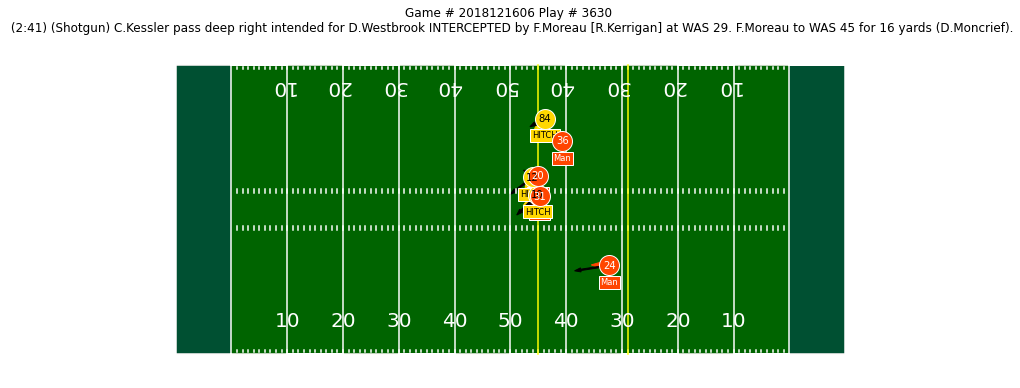

In [22]:
%%time
anim = animate_player_movement(weekData=weekFin, playId=pid, gameId=gid)
writer = FFMpegWriter(fps=10)
anim.save('anim.mp4', writer=writer)

In [23]:
Video('anim.mp4')

# WR Routes vs Different Coverages

Something to focus on is on player routes and quantifying their effectiveness against man vs zone coverages. Using the framework from above, I have a method to determine whether the corner closest to a receiver is playing in man vs zone (i.e. it doesn't generalize for the entire defense, since there are some hybrid defenses and whatnot).

What we need to do:

- Identify whether a route runner is lined up against a defender with a classification for man vs zone
- If they are, then find their outcome for the play
     - If they were targeted, if caught, and if caught then how many yards?
- Also identify players who maximize yards against man, players who maximize yards against zone
    - A step further: which routes maximize yardage vs coverages? How to adjust for potential outliers / "explosive plays"?
    - One option is to consider yard line of receiver where the ball is caught, and consider that the metric to use

In [24]:
weekFin['route'].unique()

array([nan, 'HITCH', 'CROSS', 'GO', 'SLANT', 'CORNER', 'IN', 'OUT',
       'POST', 'FLAT', 'SCREEN', 'ANGLE', 'WHEEL', 'undefined'],
      dtype=object)

In [25]:
%%time
## identify whether corner's closest opp is a WR
cbArray = np.array(weekFin.loc[weekFin['position']=='CB'])
features = list(weekFin.columns)
# get all WR ids to check against
WR_id = np.array(players.loc[players['position']=='WR']['nflId'])
# check if the CB's closest opponent is a WR
CB_opp_WR = np.in1d(cbArray[:,features.index('closestOpp(nflId)')], WR_id)

Wall time: 33.4 s


In [26]:
cbWeekFin = pd.DataFrame(cbArray, columns=features)
cbWeekFin['isAgainstWR'] = CB_opp_WR

In [27]:
cbWeekFin.loc[cbWeekFin['isAgainstWR']==True].groupby(['gameId','playId','gm_coverage']).size()

gameId      playId  gm_coverage
2018090600  75      Man             59
            146     Man            136
                    Zone            11
            168     Man             94
                    Zone            11
                                  ... 
2018123015  3969    Man            172
                    Zone            11
            4057    Man            123
                    Zone            11
            4104    Man            160
Length: 28569, dtype: int64

In [28]:
## rename displayName: from Julio Jones to J.Jones
players = pd.read_csv('nfl-big-data-bowl/players.csv')
firstLast = players['displayName'].str.split(' ', 1, expand=True)
firstLast['fInit'] = firstLast[0].str[0]
firstLast['initName'] = firstLast['fInit'] + '.' + firstLast[1]
firstLast

players = players.join(firstLast['initName'])

In [29]:
# get only abbreviated names
WRnames = players.loc[players['position']=='WR']['initName']

In [30]:
# get all receivers who are targeted on the play
df = pd.DataFrame(plays['playDescription'].str.findall('|'.join(WRnames)))
plays['involvedWR'] = df['playDescription'].str[0]

In [31]:
# dataframe organization, making sure we have info on the team player is on
WRplayers = players.loc[players['position']=='WR']
WRteams = pd.read_csv('WRteams.csv')
WRteams.drop(['Rk','AV','Age','G','GS','AV.1','Pos','Season'], axis=1, inplace=True)
WRplayers = pd.merge(WRteams, WRplayers, left_on=['Player'], right_on='displayName')
WRplayers['Team'] = ['KC' if t=='KAN' else
                     'NO' if t=='NOR' else
                     'LA' if t=='LAR' else
                     'TB' if t=='TAM' else
                     'GB' if t=='GNB' else
                     'NE' if t=='NWE' else
                     'DAL' if t=='DALOAK' or t=='DALMIA' else
                     'CLE' if t=='CLENWE' else
                     'DET' if t=='DETPHI' or t=='DETHOU' else
                     'DEN' if t=='DENHOU' else
                     'SF' if t=='SFO' else
                     'BUF' if t=='BUFKAN' or t=='BUFDEN' or t=='BUFDAL' or t=='BUFSFO' else
                     'HOU' if t=='HOUPHI' else
                     'MIN' if t=='MINNYG' else
                     'ARI' if t=='ARILAR' else
                     'NYJ' if t=='NYJTEN' else
                     'TEN' if t=='TENLAR'
                     else t for t in WRplayers['Team']]
WRplayers['Team'].unique()

array(['KC', 'NO', 'ATL', 'LA', 'HOU', 'LAC', 'IND', 'TB', 'PIT', 'MIN',
       'GB', 'CIN', 'SEA', 'NYG', 'NE', 'DAL', 'DET', 'CLE', 'CAR', 'TEN',
       'CHI', 'DEN', 'PHI', 'NYJ', 'BAL', 'OAK', 'JAX', 'ARI', 'BUF',
       'MIA', 'SF', 'WAS'], dtype=object)

In [32]:
# the names match up
plays['possessionTeam'].unique()

array(['ATL', 'PHI', 'PIT', 'CLE', 'CIN', 'IND', 'TEN', 'MIA', 'BAL',
       'BUF', 'NE', 'HOU', 'JAX', 'NYG', 'NO', 'TB', 'WAS', 'ARI', 'CAR',
       'DAL', 'GB', 'CHI', 'NYJ', 'DET', 'OAK', 'LA', 'MIN', 'LAC', 'KC',
       'SF', 'DEN', 'SEA'], dtype=object)

In [33]:
## now have dataframe of all players, narrowed down by team
WRplays = pd.merge(plays, WRplayers[['displayName','nflId', 'initName', 'Team']], left_on=['involvedWR', 'possessionTeam'], right_on=['initName', 'Team'])
## drop extra columns for cleanliness, only keep full name of involved WR and nfl ID
WRplays.drop(['involvedWR','initName','Team'], axis=1, inplace=True)

In [34]:
# get play outcomes, displayName, nflID
WRplays = WRplays[['gameId','playId','nflId','displayName','yardsToGo','passResult', 'playResult', 'epa']]
WRplays = WRplays.rename(columns={'displayName':'involvedWR','nflId':'involvedWrId'})

In [35]:
## find CBs who are against this specific WR, based on gameId, playId, then involvedWrId/closestOppId

# first find cbWeekFin who are against WR
cbVsWR = cbWeekFin.loc[cbWeekFin['isAgainstWR']==True][['gameId','playId','nflId','displayName','closestOpp(nflId)','gm_coverage']]

In [36]:
## THE GOLDEN DATAFRAME!
# clean up some column names and keys
matchups = pd.merge(cbVsWR, WRplays, left_on=['gameId','playId','closestOpp(nflId)'], right_on=['gameId','playId','involvedWrId'])
matchups.drop(['closestOpp(nflId)'], axis=1, inplace=True)
matchups.rename(columns={'nflId':'involvedCbId', 'displayName':'involvedCB'}, inplace=True)
matchups.drop_duplicates(['gameId','playId'], inplace=True)
matchups.reset_index(drop=True, inplace=True)
matchups = matchups.loc[matchups['passResult']!='S'] ## ignore sacks

In [37]:
# use this dataframe for insights and plots
# contains info on every play for which:
## 1) Receiver listed is targeted
## 2) Player of position "cornerback" is primary defender
matchups

,gameId,playId,involvedCbId,involvedCB,gm_coverage,involvedWrId,involvedWR,yardsToGo,passResult,playResult,epa
0,2018090600,75,2555383.0,Jalen Mills,Man,2495454,Julio Jones,15,C,10,0.261827
1,2018090600,146,2555383.0,Jalen Mills,Man,2560854,Calvin Ridley,10,I,0,-0.372360
2,2018090600,190,2557958.0,Sidney Jones,Man,2495454,Julio Jones,10,C,33,3.047530
3,2018090600,320,2539653.0,Robert Alford,Man,2552600,Nelson Agholor,8,C,4,-0.344096
4,2018090600,402,2552689.0,Ronald Darby,Man,2533040,Mohamed Sanu,10,I,0,-0.429863
...,...,...,...,...,...,...,...,...,...,...,...
8770,2018123011,3387,2558976.0,Kenny Moore,Man,2557848,Corey Davis,10,C,18,1.985650
8771,2018123011,3561,2543811.0,Pierre Desir,Man,2557870,Taywan Taylor,6,IN,0,-4.582358
8772,2018123011,4089,2557961.0,Quincy Wilson,Man,2557870,Taywan Taylor,14,I,0,-3.632439
8773,2018123011,4219,2558976.0,Kenny Moore,Zone,2553896,Darius Jennings,20,C,4,-0.112840


In [38]:
matchups['gm_coverage'].value_counts()

Man     6730
Zone    2036
Name: gm_coverage, dtype: int64